In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from kdg.utils import plot_2dsim, gaussian_sparse_parity, generate_gaussian_parity
from tqdm import tqdm

In [142]:
def generate_task_data(sample_size, angle, latent_dim, noise_dim):
    X, y = generate_gaussian_parity(sample_size, angle_params=angle)
    X_noise = np.random.uniform(
                low=-1, high=1, size=(sample_size, noise_dim)
            )
    X = np.concatenate((X, X_noise), axis=1)
        
    
    X , y = torch.from_numpy(X.astype('float32')), torch.from_numpy(y.astype('float32'))

    return X, y

In [143]:
class TaskDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.clone()
        self.y = y.clone()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [144]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim, nodes=2000):
        super(Encoder, self).__init__()
        self.layer1 = nn.Linear(input_size, nodes)
        self.bn1 = nn.BatchNorm1d(nodes)
        self.layer2 = nn.Linear(nodes, nodes)
        self.bn2 = nn.BatchNorm1d(nodes)
        self.layer3 = nn.Linear(nodes, nodes)
        self.bn3 = nn.BatchNorm1d(nodes)
        self.layer4 = nn.Linear(nodes, nodes)
        self.bn4 = nn.BatchNorm1d(nodes)
        self.output = nn.Linear(nodes, latent_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(self.bn1(x))
        x = self.layer2(x)
        x = F.relu(self.bn2(x))
        x = self.layer3(x)
        x = F.relu(self.bn3(x))
        x = self.layer4(x)
        x = F.relu(self.bn4(x))
        x = self.output(x)

        return x
        

In [145]:
class Head(nn.Module):
    def __init__(self, latent_dim, output, nodes=50):
        super(Head, self).__init__()
        self.layer1 = nn.Linear(latent_dim, nodes)
        self.layer2 = nn.Linear(nodes, nodes)
        self.output = nn.Linear(nodes, output)
        

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.output(x)

        return x

In [158]:
class ContrastLoss(nn.Module):
    def __init__(self, latent_dim, margin=0.3, replay_const=1e-1):
        super(ContrastLoss, self).__init__()
        self.margin = margin
        self.replay_const = replay_const
        #self.head_to_consider = head_to_consider

    def forward(self, inputs, targets, inputs_replay, targets_replay):
        dis_embedding = torch.cdist(
                            inputs,
                            inputs,
                            p=2.0
                        )

        #idx = torch.randperm(targets.shape[1])[:self.head_to_consider]
        #print(idx)
        #targets = targets[:,:self.head_to_consider]
        number_of_heads = targets.shape[1]
        kernel_partition = torch.sum(
                            targets.view(1,-1,number_of_heads)==targets.view(-1,1,number_of_heads),
                            dim=2)/number_of_heads
        
        #print(kernel_partition, dis_embedding)
        dis_partition = (1-kernel_partition)>1e-12

        ############################################################
        dis_embedding_replay = torch.cdist(
                            inputs_replay,
                            inputs_replay,
                            p=2.0
                        )
        number_of_heads_replay = targets_replay.shape[1]
        kernel_partition_replay = torch.sum(
                            targets_replay.view(1,-1,number_of_heads_replay)==targets_replay.view(-1,1,number_of_heads_replay),
                            dim=2)/number_of_heads_replay
        
        #print(kernel_partition, dis_embedding)
        dis_partition_replay = (1-kernel_partition_replay)>1e-12

        
        #print(dis_partition)
        loss = torch.mul(
                        kernel_partition,
                        dis_embedding
                    ) + torch.clamp(torch.mul(
                        dis_partition,
                        self.margin-dis_embedding
                        ), 0.0)
        
        loss_replay = torch.mul(
                        kernel_partition_replay,
                        dis_embedding_replay
                    ) + torch.clamp(torch.mul(
                        dis_partition_replay,
                        self.margin-dis_embedding_replay
                        ), 0.0)
                
        return loss.mean() + self.replay_const*loss_replay.mean()

In [159]:
class ClassificationLoss(nn.Module):
    def __init__(self):
        super(ClassificationLoss, self).__init__()

    def forward(self, inputs, targets):
        print(inputs.size(), targets.size())
        loss = -1 * (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        return loss.mean()

In [208]:
total_task = 10
heads = {}
classes_per_task = 2
sample_per_task = 50
noise_dim = 8
latent_dim = 2
total_node_per_layer = 3100
epoch_per_task_encoder = 100
epoch_per_task_head = 100
total_task_seen = 0
learning_rate_encoder = 3e-4
learning_rate_head = 5e-2
batch_size = 64
margin = 4.5
replay_const = 3e-2
X_replay = []
y_replay = []
###########################
task_angles = np.linspace(0,np.pi/12, total_task)
#np.random.shuffle(task_angles)

###########################
encoder = Encoder(input_size=noise_dim+latent_dim, latent_dim=latent_dim, nodes=total_node_per_layer)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr = learning_rate_encoder, weight_decay = 1e-14)

for ii, angle in enumerate(task_angles):
    print('Doing Task ', ii+1)

    criterion_encoder = ContrastLoss(latent_dim, margin=margin, replay_const=replay_const)
    
    X, y = generate_task_data(sample_per_task, angle, latent_dim, noise_dim)
    y = y.view(-1,1)

    if ii == 0:
        X_replay = X
        #criterion_encoder.replay_const = 0
    else:
        X_replay = torch.cat((X_replay, X))
        #criterion_encoder.replay_const = replay_const
    
    with torch.no_grad():
        embedding = encoder(X)
        
        for jj in range(total_task_seen):
            head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
            y = torch.cat((y, head_predicted_label),
                        dim=1)

    
    #######################
    if ii == 0:
        y_replay = y
    else:
        with torch.no_grad():
            embedding = encoder(X_replay)
            
            for jj in range(total_task_seen):
                head_predicted_label = heads[jj](embedding).argmax(1).view(-1,1)
    
                if jj == 0:
                    y_replay = head_predicted_label
                else:
                    y_replay = torch.cat((y_replay, head_predicted_label),
                                dim=1)

 
    
    train_loader = DataLoader(TaskDataset(X, y), batch_size=batch_size,
                                          shuffle=True)   
    replay_loader = DataLoader(TaskDataset(X_replay, y_replay), batch_size=batch_size,
                                          shuffle=True) 
    
    #task_data[ii] = train_loader
    ## train encoder ##
    for epoch in range(epoch_per_task_encoder):
        running_loss = 0.0

        count = 0
        for (X_, y_), (X_r, y_r) in zip(train_loader, replay_loader):
            encoder_optimizer.zero_grad()
            embedding = encoder(X_)
            embedding_replay = encoder(X_r)
            
            loss = criterion_encoder(embedding, y_, embedding_replay, y_r)
            #print(X_r.shape)
            loss.backward()
            encoder_optimizer.step()

            running_loss += loss.item()
            count += 1

    print("Epoch :", epoch+1, "loss :", running_loss/(count+1))
            

    ## train head ##
    heads[ii] = Head(latent_dim=latent_dim, output=classes_per_task)
    head_optimizer = torch.optim.SGD(heads[ii].parameters(), lr=learning_rate_head, momentum=0.9)
    criterion_head = nn.CrossEntropyLoss()
        
    for epoch in range(epoch_per_task_head):
        for X_, y_ in train_loader:
            head_optimizer.zero_grad()
            
            with torch.no_grad():
                embedding = encoder(X_)

            predicted_y = heads[ii](embedding)
            loss_head = criterion_head(predicted_y, y_[:,0].long())
            loss_head.backward()
            head_optimizer.step()
            
    print(f'head {ii+1} Epoch : {epoch+1}, loss: {loss_head:.4f}')

    total_task_seen += 1

    for kk in range(total_task_seen):
        X , y = generate_task_data(1000, task_angles[kk], latent_dim, noise_dim)
        
        with torch.no_grad():
            embedding = encoder(X)
            head_predicted_label = heads[kk](embedding).argmax(1).view(-1,1)
    
        print(f'Task {kk+1} accuracy: ', torch.sum(y.view(-1,1)==head_predicted_label)/10)  
    #break

Doing Task  1
Epoch : 100 loss : 0.03493836522102356
head 1 Epoch : 100, loss: 0.0000
Task 1 accuracy:  tensor(69.9000)
Doing Task  2
Epoch : 100 loss : 0.424327552318573
head 2 Epoch : 100, loss: 0.0000
Task 1 accuracy:  tensor(76.6000)
Task 2 accuracy:  tensor(81.7000)
Doing Task  3
Epoch : 100 loss : 0.5912309885025024
head 3 Epoch : 100, loss: 0.0000
Task 1 accuracy:  tensor(78.3000)
Task 2 accuracy:  tensor(82.5000)
Task 3 accuracy:  tensor(80.2000)
Doing Task  4
Epoch : 100 loss : 0.6748536825180054
head 4 Epoch : 100, loss: 0.0305
Task 1 accuracy:  tensor(82.6000)
Task 2 accuracy:  tensor(86.4000)
Task 3 accuracy:  tensor(88.4000)
Task 4 accuracy:  tensor(87.5000)
Doing Task  5
Epoch : 100 loss : 0.6226997375488281
head 5 Epoch : 100, loss: 0.1227
Task 1 accuracy:  tensor(84.4000)
Task 2 accuracy:  tensor(89.3000)
Task 3 accuracy:  tensor(88.4000)
Task 4 accuracy:  tensor(89.8000)
Task 5 accuracy:  tensor(89.3000)
Doing Task  6
Epoch : 100 loss : 0.6319965124130249
head 6 Epoch 

In [209]:
for ii in range(total_task):
    X , y = generate_task_data(10000, task_angles[ii], latent_dim, noise_dim)
    embedding = encoder(X)
    head_predicted_label = heads[ii](embedding).argmax(1).view(-1,1)

    print(f'T ask {ii+1} accuracy: ', torch.sum(y.view(-1,1)==head_predicted_label)/10000)    

T ask 1 accuracy:  tensor(0.9025)
T ask 2 accuracy:  tensor(0.9098)
T ask 3 accuracy:  tensor(0.9016)
T ask 4 accuracy:  tensor(0.9075)
T ask 5 accuracy:  tensor(0.9059)
T ask 6 accuracy:  tensor(0.9017)
T ask 7 accuracy:  tensor(0.9124)
T ask 8 accuracy:  tensor(0.9147)
T ask 9 accuracy:  tensor(0.8771)
T ask 10 accuracy:  tensor(0.9168)


In [210]:
task = 0
X , y = generate_task_data(10000, task_angles[task], latent_dim, noise_dim)

In [211]:
embedding = encoder(X)
head_predicted_label = heads[task](embedding).argmax(1).view(-1,1)

In [212]:
criterion_encoder = ContrastLoss(latent_dim)
#criterion_encoder(embedding, y, 3)

<AxesSubplot: >

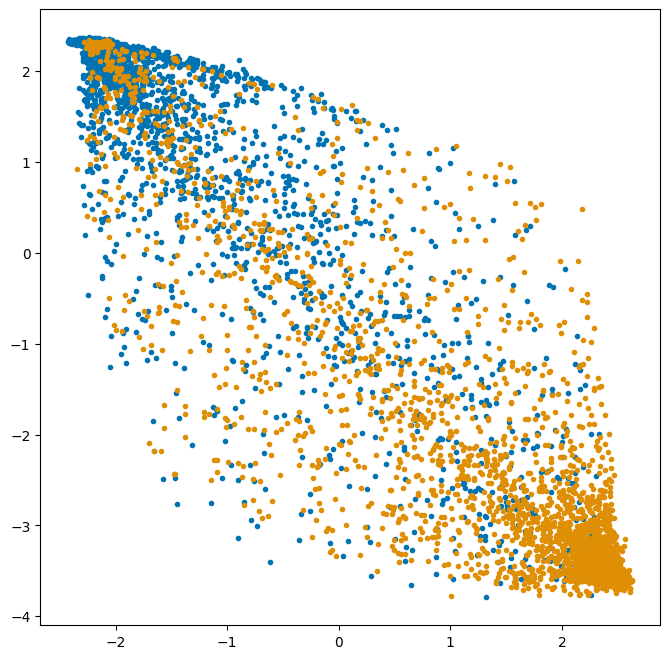

In [213]:
plot_2dsim(embedding.detach().numpy(), y.view(-1).numpy().astype('int'))
#plot_2dsim(embedding.detach().numpy(), y[:,0].view(-1).numpy().astype('int'))

<AxesSubplot: >

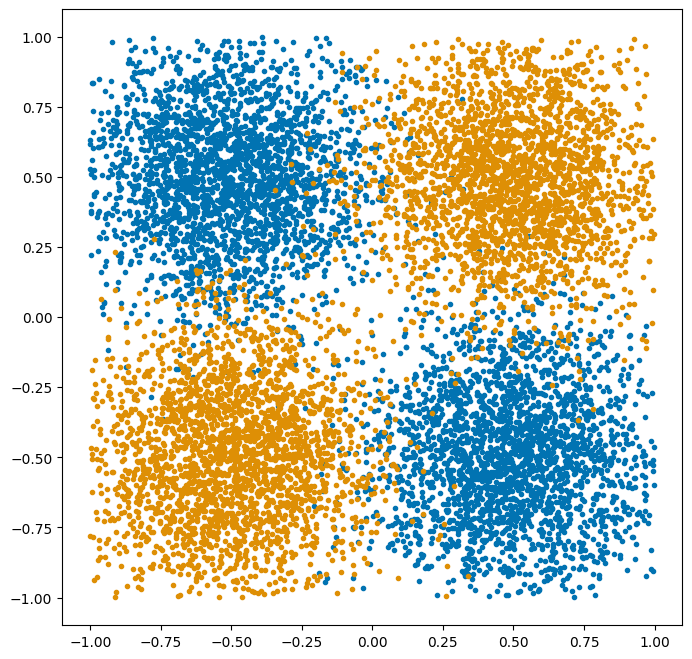

In [201]:
plot_2dsim(X.detach().numpy()[:,:2], y.view(-1).numpy().astype('int'))

In [91]:
torch.sum(y.view(-1,1)==head_predicted_label)/10000

tensor(0.8862)

# Todos
- How much capacity is needed
- Do we need supervised replay?
- Contrastive lifelong learning